In [ ]:
image_extensions = ['.tif', '.tiff', '.bmp', '.jpg', '.jpeg', '.gif', '.png', '.eps']

### convert sampled dataset to yCbCr images
### upload the zip file inside 5th training folder


In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

# verify CUDA
!/usr/local/cuda/bin/nvcc --version



Cloning into 'darknet'...
remote: Enumerating objects: 15316, done.
remote: Total 15316 (delta 0), reused 0 (delta 0), pack-reused 15316
Receiving objects: 100% (15316/15316), 13.70 MiB | 17.51 MiB/s, done.
Resolving deltas: 100% (10407/10407), done.
/content/darknet
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
!make

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**before setting up the training keep these things in mind**

1.for a new training run always create a new folder like used here yolo_3rd_run/

2.modify the obj.data and obj.zip according to your training set.and set the new path where ur weights will be stored in obj.data

3.always make sure that the folder that you zip to obj.zip should have its name as obj else what can happen that when you are copying obj to darknet/data/ folder and unzipping it the name of the folder will not be obj.

4.for the below 4 cells for setting up training change everything

In [ ]:
!ls /content/gdrive/MyDrive/

In [ ]:
# copy the .zip file into the root directory of cloud VM
!cp /content/gdrive/MyDrive/yolov4-tiny-ycbcr-dataset3/obj.zip ../

In [ ]:
# unzip the zip file and its contents should now be in /darknet/data/obj
!unzip ../obj.zip -d data/

In [ ]:
!cp /content/gdrive/MyDrive/yolov4-tiny-ycbcr-dataset3/yolov4-tiny-custom.cfg ./cfg

In [ ]:
# upload the obj.names and obj.data files to cloud VM from Google Drive
!cp /content/gdrive/MyDrive/yolov4-tiny-ycbcr-dataset3/obj.names ./data
!cp /content/gdrive/MyDrive/yolov4-tiny-ycbcr-dataset3/obj.data ./data

In [ ]:
!cp /content/gdrive/MyDrive/yolov4-tiny-ycbcr-dataset3/process.py ./
!python process.py

/content/darknet


In [ ]:
# upload pretrained convolutional layer weights
# if rerunning after some epochs then get the weights from backup folder else if running for first time then run the below command
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29

In [ ]:
# train your custom detector 
!./darknet detector train data/obj.data cfg/yolov4-tiny-custom.cfg \
yolov4-tiny.conv.29 \
-dont_show -map 

**Run the prediction for the test set**

In [ ]:
# need to set our custom cfg to test mode 
#uncomment the #Test section in yolov3-custom.cfg
%cd cfg
!sed -i 's/batch=1/batch=64/' yolov4-tiny-custom.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' yolov4-tiny-custom.cfg
%cd ..

/content/darknet/cfg
/content/darknet


In [ ]:
#store every test image path in a .txt file inside /content/gdrive/MyDrive/TEST_SET_YOLOV3/test_paths
#Different file types..
import glob

test_images_path = []
for files in image_extensions:
    test_images_path.extend\
    (glob.glob(r"/content/gdrive/MyDrive/TEST_SET_yolov4-Tiny-Ycbcr_dataset3/test_for_conf_mtx/*"+files))

In [ ]:
test_images_path

In [ ]:
with open("/content/gdrive/MyDrive/TEST_SET_yolov4-Tiny-Ycbcr_dataset3/test_paths.txt", "w") as outfile:
    for image in test_images_path:
        outfile.write(image)
        outfile.write("\n")
    outfile.close()

In [ ]:
# store the predictions on test data in a json file inside /content/gdrive/MyDrive/TEST_SET_YOLOV3_3rd/test_pred.json
!./darknet detector test data/obj.data cfg/yolov4-tiny-custom.cfg \
/content/gdrive/MyDrive/yolov4-tiny-ycbcr-dataset3/backup/yolov4-tiny-custom_best.weights \
-ext_output -dont_show -out \
/content/gdrive/MyDrive/TEST_SET_yolov4-Tiny-Ycbcr_dataset3/test_pred.json < \
/content/gdrive/MyDrive/TEST_SET_yolov4-Tiny-Ycbcr_dataset3/test_paths.txt

**store the prediction in .npy**

In [ ]:
import jsonprediction_to_array as ja
ja.process_test('/content/gdrive/MyDrive/TEST_SET_yolov4-Tiny-Ycbcr_dataset3/test_pred.json','/content/gdrive/MyDrive/TEST_SET_yolov4-Tiny-Ycbcr_dataset3/BBOXES')

/content/jsonprediction_to_array.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  labels = np.array([np.array([np.array(xi) for xi in GT_BBOXES[i]]) for i in range(len(GT_BBOXES))])
/content/jsonprediction_to_array.py:134: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  detections = np.array([np.array([np.array(xi) for xi in PRED_BBOXES[i]]) for i in range(len(PRED_BBOXES))])


**run the inference on unit test set**

In [ ]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 166, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	                           ->  

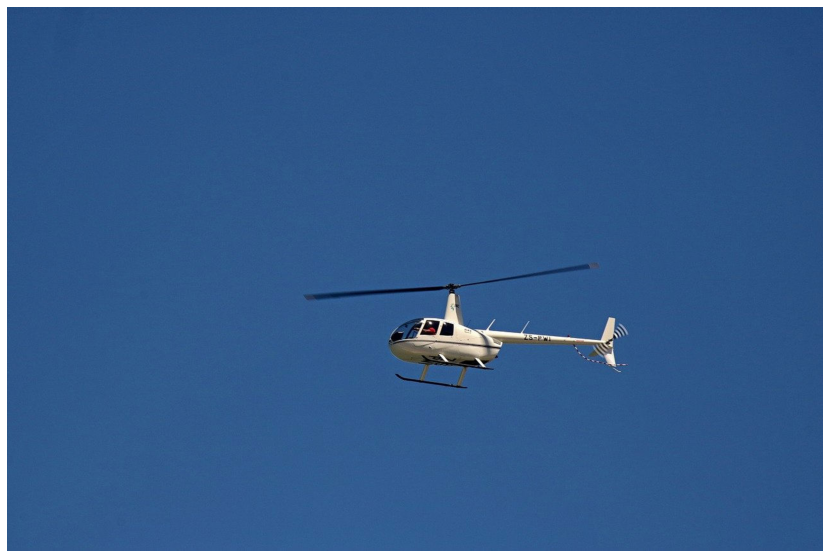

In [ ]:
!./darknet detector test data/obj.data cfg/yolov4-tiny-custom.cfg \
/content/gdrive/MyDrive/Yolov4_Tiny_rgb_dataset3/backup/yolov4-tiny-custom_best.weights \
/content/gdrive/MyDrive/TEST_SET_yolov4_tiny_rgb_dataset3/test_for_conf_mtx_new/ts9.jpeg -thresh 0.3
imShow('predictions.jpg')

**Get the confusion matrix for the test dataset**

In [ ]:
#Import the confusion_matrix_detection.py

import confusion_matrix_detection as cf
from functools import partial
import numpy as np


#get the gtruth bounding boxes and predictions from drive
np_load_old = partial(np.load)

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
with open('/content/gdrive/MyDrive/TEST_SET_yolov4-Tiny-Ycbcr_dataset3/BBOXES/labels.npy', 'rb') as f:
    labels = np.load(f)

with open('/content/gdrive/MyDrive/TEST_SET_yolov4-Tiny-Ycbcr_dataset3/BBOXES/detections.npy', 'rb') as f:
    detections = np.load(f)
    
# restore np.load for future normal usage
np.load = np_load_old

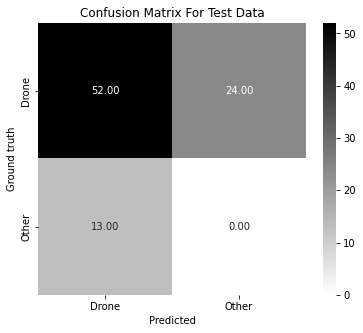

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (6,5))
mtx = cf.Confusion_Matrix(labels=labels,detections=detections,CONFD_THRESHOLD=0.4)
sns.heatmap(mtx,cmap='binary',annot=True,fmt='.2f',\
                xticklabels=['Drone' , 'Other'], yticklabels=['Drone','Other'])
plt.ylabel('Ground truth')
plt.xlabel('Predicted')
plt.title('Confusion Matrix For Test Data')
plt.show()

In [ ]:
# run your custom detector on a video with this command (upload a video to your google drive to test, the thresh flag sets the minimum accuracy required for object detection).This saves the output video with the detections in your output path

!./darknet detector demo data/obj.data cfg/yolov4-tiny-custom.cfg /mydrive/yolov4-tiny/training/yolov4-tiny-custom_best.weights -dont_show \
 -i 0 -out_filename \
/mydrive/mask_test_videos/result.avi 